In [90]:
import numpy as np
import taichi as ti
import matplotlib.pyplot as plt
import scipy

ti.init(arch=ti.gpu)

[Taichi] Starting on arch=cuda


In [83]:
def erf(x):
    # save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # constants
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911

    # A&S formula 7.1.26
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * ti.exp(-x * x)
    return sign * y


def erfc(x):
    return 1 - erf(x)

In [84]:
def mgkfs_recursive_moments(T0, T1, u, mfp):
    m = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    m[0] = T0
    m[1] = T1
    for k in range(5):
        m[k + 2] = m[k + 1] * u + m[k] * (k + 1) / (2 * mfp)
    return m

In [85]:
D = 2
K = 0
b = K + D

PI = 3.1415926535897
EPS = 1e-3
CFL = 0.4

c_s = 1
T_ref = 1.0
gamma = (b + 2) / b
Rg = c_s**2 / (gamma * T_ref)

In [106]:
rho_L, rho_R = 1.2, 1.2
u1_L, u1_R = -0.5, -0.5
u2_L, u2_R = 0.6, 0.6
T_L, T_R = 1.0, 1.0
mfp_L, mfp_R = 1.0 / (2 * Rg * T_L), 1.0 / (2 * Rg * T_R)
print(mfp_L, mfp_R)

1.0 1.0


In [107]:
T0 = erfc(-ti.sqrt(mfp_L) * u1_L) / 2.0
# T0 = scipy.special.erfc(-ti.sqrt(mfp_L) * u1_L) / 2.0
T1 = u1_L * T0 + ti.exp(-mfp_L * u1_L**2) / (2 * ti.sqrt(PI * mfp_L))
M_L = mgkfs_recursive_moments(T0, T1, u1_L, mfp_L)

T0 = erfc(ti.sqrt(mfp_R) * u1_R) / 2.0
# T0 = scipy.special.erfc(ti.sqrt(mfp_R) * u1_R) / 2.0
T1 = u1_R * T0 - ti.exp(-mfp_R * u1_R**2) / (2 * ti.sqrt(PI * mfp_R))
M_R = mgkfs_recursive_moments(T0, T1, u1_R, mfp_R)

print(M_L)
print(M_R)

[0.23974999 0.09982065 0.06996467 0.06483831 0.07252785 0.0934127
 0.13461328]
[ 0.76025001 -0.59982065  0.68003533 -0.93983831  1.48997215 -2.6246627
  5.03726172]


In [108]:
rho_i = M_L[0] * rho_L + M_R[0] * rho_R
u1 = (M_L[1] * rho_L + M_R[1] * rho_R) / rho_i
u2 = (M_L[0] * rho_L * u2_L + M_R[0] * rho_R * u2_R) / rho_i

print(rho_i)
print(u1)
print(u2)

1.2
-0.5
0.6


In [109]:
T0 = (u2_L**2 + (b - 1) * Rg * T_L) * M_L[0]
T1 = (u2_R**2 + (b - 1) * Rg * T_R) * M_R[0]
E_i = ((M_L[2] + T0) * rho_L + (M_R[2] + T1) * rho_R) / (2 * rho_i)
e_i = ti.max(E_i - (u1**2 + u2**2) / 2.0, EPS)
mfp_i = 1.0 / (2 * e_i * (gamma - 1))

print(mfp_i)

1.0000000000000002


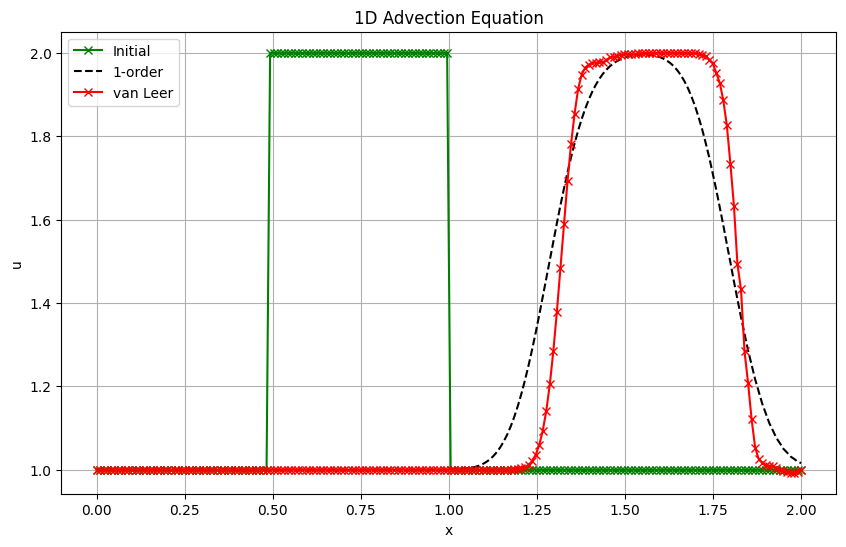

In [188]:
from scipy.integrate import solve_ivp

# Keep original parameters
nx = 200
nt = 20
dx = 2.0 / (nx - 1)
dt = 0.01
c = 4.0
t_span = (0, dt * nt)

x = np.linspace(0, 2, nx)
u_base = np.ones(nx)
u_base[int(0.5 / dx) : int(1 / dx + 1)] = 2

# Keep original methods
u_linear = u_base.copy()
u_second = u_base.copy()


def flux(u):
    return c * u


# Original 1st order method
for n in range(nt):
    un = u_linear.copy()
    for i in range(1, nx):
        u_linear[i] = un[i] - dt / dx * (flux(un[i]) - flux(un[i - 1]))

# Original 2nd order method
for n in range(nt):
    un = u_second.copy()
    for i in range(1 + 1, nx - 1):
        u_i = (un[i] + un[i + 1]) / 2
        u_i_minus = (un[i - 1] + un[i]) / 2
        u_second[i] = un[i] - dt / dx * (flux(u_i) - flux(u_i_minus))


def advection_o1(t, u):
    dudx = np.zeros_like(u)
    for i in range(1, nx):
        dudx[i] = -(flux(u[i]) - flux(u[i - 1])) / dx
    return dudx


def advection_o2(t, u):
    dudx = np.zeros_like(u)
    for i in range(1, nx - 1):
        u_i = (un[i] + un[i + 1]) / 2
        u_i_minus = (un[i - 1] + un[i]) / 2
        dudx[i] = -(flux(u_i) - flux(u_i_minus)) / dx
    return dudx


def van_leer_limiter(r):
    return (r + abs(r)) / (1 + abs(r))


def advection_o3(t, u):
    dudx = np.zeros_like(u)

    for i in range(1, nx - 1):
        delta_minus = u[i] - u[i - 1]
        delta_plus = u[i + 1] - u[i]

        eps = 1e-10

        if abs(delta_minus) > eps:
            r = delta_plus / delta_minus
        else:
            r = delta_plus / eps

        phi = van_leer_limiter(r)

        u_half = u[i] + 0.5 * phi * delta_minus
        u_half_minus = u[i - 1] + 0.5 * phi * (u[i - 1] - u[i - 2])

        dudx[i] = -(flux(u_half) - flux(u_half_minus)) / dx
    return dudx


sol_o1 = solve_ivp(
    advection_o1, t_span, u_base, method="RK45", t_eval=np.linspace(0, dt * nt, nt + 1), rtol=1e-3, atol=1e-8
)
sol_o2 = solve_ivp(
    advection_o2, t_span, u_base, method="RK45", t_eval=np.linspace(0, dt * nt, nt + 1), rtol=1e-3, atol=1e-8
)
sol_v = solve_ivp(
    advection_o3, t_span, u_base, method="RK45", t_eval=np.linspace(0, dt * nt, nt + 1), rtol=1e-3, atol=1e-8
)

plt.figure(figsize=(10, 6))
plt.plot(x, u_base, "g-x", label="Initial")
plt.plot(x, sol_o1.y[:, -1], "k--", label="1-order")
# plt.plot(x, sol_o2.y[:, -1], "r-x", label="2-order")
plt.plot(x, sol_v.y[:, -1], "r-x", label="van Leer")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D Advection Equation")
plt.legend()
plt.show()
